In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils

In [2]:
anr_tag = 'NOAK'
wacc = utils.WACC
results_path = f'./results/raw_results_anr_{anr_tag}_h2_wacc_{str(wacc)}.xlsx'
clean_save_path = f'./results/clean_results_anr_{anr_tag}_h2_wacc_{str(wacc)}.xlsx'


In [3]:
save_fig_path = './results/ammonia_anr_'+anr_tag+'_h2'

In [4]:
df = pd.read_excel(results_path, sheet_name='ammonia')
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)


In [5]:
anr_param = pd.read_excel('ANRs.xlsx', sheet_name=anr_tag)

### Cumulative number of viable ammonia plants and ANR modules

In [6]:
anr_thermal_power = anr_param[['Power in MWt', 'Reactor']]
df = df.merge(anr_thermal_power, how='inner', left_on=['ANR type'], right_on=['Reactor'])
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df['Deployed Power (MWt)'] = df['Power in MWt']*df['# ANR modules']
df['ANR Nameplate Capacity (GWt)'] = df['Deployed Power (MWt)'].cumsum()/1000
df['Cum h2 dem (t/day)'] =df['H2 Dem. (kg/day)'].cumsum()/1000
df['Cum h2 dem (%)'] = 100*df['H2 Dem. (kg/day)'].cumsum()/df['H2 Dem. (kg/day)'].sum()
df.tail(10)

,id,state,Ammonia capacity (tNH3/year),H2 Dem. (kg/day),Aux Elec Dem. (MWe),Net Revenues ($/year),HTSE,PEM,Alkaline,Ann. CO2 emissions (kgCO2eq/year),...,Depl. ANR Cap. (MWe),ANR type,# ANR modules,Breakeven price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Cum h2 dem (t/day),Cum h2 dem (%)
25,Co_E.,IL,350000,483970.750863,0.198107,-2.237515e+08,484,0,0,4.375515e+07,...,480.0,PBR-HTGR,6,20.683323,200,PBR-HTGR,1200,48.80,23624.686510,94.564676
26,Dy_Ch,WY,175000,241985.375431,0.099053,-1.141244e+08,242,0,0,2.187757e+07,...,240.0,PBR-HTGR,3,21.100236,200,PBR-HTGR,600,49.40,23866.671885,95.533293
27,Ko_Fo,OA,340000,470143.015124,0.192447,-2.226384e+08,471,0,0,4.257991e+07,...,480.0,PBR-HTGR,6,21.187181,200,PBR-HTGR,1200,50.60,24336.814901,97.415177
28,LS_Ch,AL,170000,235071.507562,0.096223,-1.136107e+08,236,0,0,2.133516e+07,...,240.0,PBR-HTGR,3,21.624528,200,PBR-HTGR,600,51.20,24571.886408,98.356119
19,Ne_Ge,NE,90000,124449.621650,0.050942,-6.171867e+07,125,0,0,1.172351e+07,...,141.0,iMSR,1,22.191206,300,iMSR,300,51.50,24696.336030,98.854265
29,Au_Gr,TN,60000,82966.414434,0.033961,-4.123941e+07,83,0,0,7.503466e+06,...,80.0,PBR-HTGR,1,22.241838,200,PBR-HTGR,200,51.70,24779.302444,99.186362
30,U._Mo,TN,60000,82966.414434,0.033961,-4.123941e+07,83,0,0,7.503466e+06,...,80.0,PBR-HTGR,1,22.241838,200,PBR-HTGR,200,51.90,24862.268859,99.518459
31,Gr_Cr,IA,32000,44248.754365,0.018113,-3.514744e+07,45,0,0,3.386020e+06,...,33.5,Micro,5,35.578438,20,Micro,100,52.00,24906.517613,99.695578
32,Ch_El,CA,25000,34569.339347,0.014150,-2.894614e+07,35,0,0,2.633571e+06,...,26.8,Micro,4,37.508614,20,Micro,80,52.08,24941.086952,99.833951
33,Sh_Go,GA,30000,41483.207217,0.016981,-3.493365e+07,42,0,0,3.160286e+06,...,33.5,Micro,5,37.723065,20,Micro,100,52.18,24982.570160,100.000000


In [7]:
df['Viable ANR modules count'] = df['# ANR modules'].cumsum()
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df['Viable ANR ammonia plants count'] = df.index+1
df.tail(10)

,id,state,Ammonia capacity (tNH3/year),H2 Dem. (kg/day),Aux Elec Dem. (MWe),Net Revenues ($/year),HTSE,PEM,Alkaline,Ann. CO2 emissions (kgCO2eq/year),...,# ANR modules,Breakeven price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Cum h2 dem (t/day),Cum h2 dem (%),Viable ANR modules count,Viable ANR ammonia plants count
24,Co_E.,IL,350000,483970.750863,0.198107,-2.237515e+08,484,0,0,4.375515e+07,...,6,20.683323,200,PBR-HTGR,1200,48.80,23624.686510,94.564676,180,25
25,Dy_Ch,WY,175000,241985.375431,0.099053,-1.141244e+08,242,0,0,2.187757e+07,...,3,21.100236,200,PBR-HTGR,600,49.40,23866.671885,95.533293,183,26
26,Ko_Fo,OA,340000,470143.015124,0.192447,-2.226384e+08,471,0,0,4.257991e+07,...,6,21.187181,200,PBR-HTGR,1200,50.60,24336.814901,97.415177,189,27
27,LS_Ch,AL,170000,235071.507562,0.096223,-1.136107e+08,236,0,0,2.133516e+07,...,3,21.624528,200,PBR-HTGR,600,51.20,24571.886408,98.356119,192,28
28,Ne_Ge,NE,90000,124449.621650,0.050942,-6.171867e+07,125,0,0,1.172351e+07,...,1,22.191206,300,iMSR,300,51.50,24696.336030,98.854265,193,29
29,Au_Gr,TN,60000,82966.414434,0.033961,-4.123941e+07,83,0,0,7.503466e+06,...,1,22.241838,200,PBR-HTGR,200,51.70,24779.302444,99.186362,194,30
30,U._Mo,TN,60000,82966.414434,0.033961,-4.123941e+07,83,0,0,7.503466e+06,...,1,22.241838,200,PBR-HTGR,200,51.90,24862.268859,99.518459,195,31
31,Gr_Cr,IA,32000,44248.754365,0.018113,-3.514744e+07,45,0,0,3.386020e+06,...,5,35.578438,20,Micro,100,52.00,24906.517613,99.695578,200,32
32,Ch_El,CA,25000,34569.339347,0.014150,-2.894614e+07,35,0,0,2.633571e+06,...,4,37.508614,20,Micro,80,52.08,24941.086952,99.833951,204,33
33,Sh_Go,GA,30000,41483.207217,0.016981,-3.493365e+07,42,0,0,3.160286e+06,...,5,37.723065,20,Micro,100,52.18,24982.570160,100.000000,209,34


### Avoided carbon emissions

In [8]:
ammonia_demand_df = pd.read_excel('./h2_demand_ammonia_us_2022.xlsx', sheet_name='processed')
df = df.merge(ammonia_demand_df, on='id')
ratio_co2_to_nh3 = 2.30 # tCO2eq/tNH3
df['NG path GHG (tCO2/year)'] = df.apply(lambda x:x['Capacity (tNH3/year)']*2.30, axis=1)

In [9]:
df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = (df['NG path GHG (tCO2/year)'] - (df['Ann. CO2 emissions (kgCO2eq/year)']/1e3))/1e6
df['Viable avoided emissions (MMT-CO2/year)'] = df['Ann. avoided CO2 emissions (MMT-CO2/year)'].cumsum()
df[['Breakeven price ($/MMBtu)', 'Viable avoided emissions (MMT-CO2/year)']].tail(50)


,Breakeven price ($/MMBtu),Viable avoided emissions (MMT-CO2/year)
0,17.273092,8.540105
1,17.339362,10.742927
2,17.664422,13.130181
3,17.708655,14.095908
4,17.809608,15.756180
5,17.886737,16.244418
6,17.977442,16.960557
7,18.024359,17.904597
8,18.184595,19.065694
9,18.354918,19.988046


### Save

In [10]:
df_clean = df[["id", 'state', 'Capacity (tNH3/year)', 'H2 Dem. (kg/day)', 'HTSE', 'ANR type', '# ANR modules', \
               'Net Revenues ($/year)', 'Ann. avoided CO2 emissions (MMT-CO2/year)', 'Breakeven price ($/MMBtu)', \
                'Viable avoided emissions (MMT-CO2/year)', 'Cum h2 dem (%)']]
df_clean['H2 Dem. (kg/day)'] /=1e3

df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))

df_clean['H2 Dem. (kg/day)'] = df_clean['H2 Dem. (kg/day)'].apply(lambda x:np.round(x,1))

df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Net Revenues ($/year)']/(1e6*df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)'])
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Avoided cost of CO2 ($/ton)'].apply(lambda x:np.round(np.abs(x),1))

df_clean['Net Revenues ($/year)'] = df_clean['Net Revenues ($/year)'].apply(lambda x: np.round(x/1e6,1))

df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']= df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)'].apply(lambda x: np.round(x,1))

df_clean['Breakeven price ($/MMBtu)'] = df_clean['Breakeven price ($/MMBtu)'].apply(lambda x : np.round(x,1))

df_clean.rename(columns={'H2 Dem. (kg/day)': 'Demand (MT H2/day)',
                         'Net Rev. ($/year)': 'Net Rev. (M$/year)', 
                         'ANR type': 'ANR', 
                         '# ANR modules': '#'}, inplace=True)


C:\Users\mgarrou\AppData\Local\Temp\ipykernel_10092\2133884262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['H2 Dem. (kg/day)'] /=1e3
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_10092\2133884262.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_10092\2133884262.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [11]:
sheet_name = 'ammonia'
excel_file = clean_save_path
try:
# Load the existing Excel file
  with pd.ExcelFile(excel_file, engine='openpyxl') as xls:
      with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
              df.to_excel(writer, sheet_name=sheet_name, index=False)
except FileNotFoundError:
    # If the file doesn't exist, create a new one and write the DataFrame to it
    df.to_excel(excel_file, sheet_name=sheet_name, index=False)

### Plots

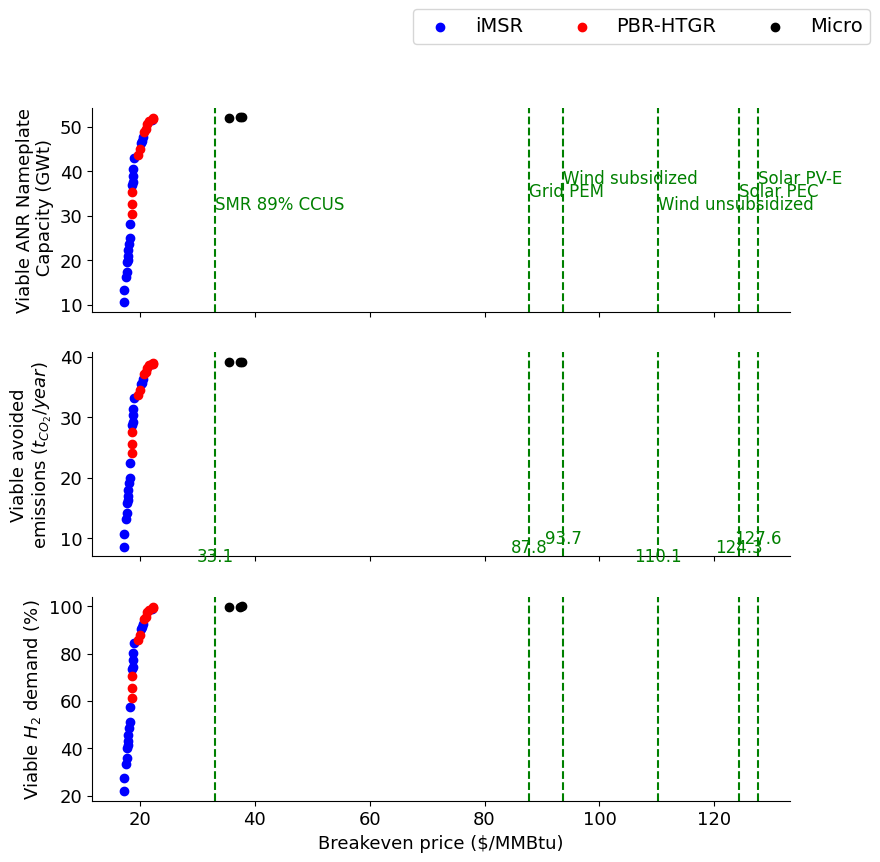

In [12]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 13

# Create subplots
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(9, 9))

# Get unique ANR types and assign colors
anr_types = df['ANR type'].unique()

colors = ['blue', 'red', 'black']  # Adjust the colors according to the unique ANR types
# Initialize empty handles for legend
handles = []
# Plotting the data as scatter plots with different colors for each ANR type
labels = {'ANR Nameplate Capacity (GWt)': 'Viable ANR Nameplate\n Capacity (GWt)',
            'Viable avoided emissions (MMT-CO2/year)': 'Viable avoided\n'r'emissions ($t_{CO_2}/year$)',
            'Cum h2 dem (%)':r'Viable $H_2$ demand (%)'}
for i, col in enumerate(['ANR Nameplate Capacity (GWt)', 'Viable avoided emissions (MMT-CO2/year)', 'Cum h2 dem (%)']):
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs[i].scatter(subset['Breakeven price ($/MMBtu)'], subset[col], color=color, label=f'{anr_type}')
    axs[i].set_ylabel(labels[col])

    # Remove the top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)


    # Adding vertical lines
    res_be = pd.read_csv('./results/res_be_ammonia.csv')
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)

    #ng_vertical_lines = [6.4, 13, 40]
    #ng_labels = ['US NG\navg 2022', 'CA NG\ndelivered 2022', 'EU NG\n 2022']
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    #for line in ng_vertical_lines:
     #   axs[i].axvline(x=line, linestyle='--', color='grey')
    for l,line in enumerate(res_vert_lines):
        axs[i].axvline(x=line, linestyle='--',color='green')


res_labels = res_be['RES']
count = 0
for x, label in zip(res_vert_lines, res_labels):
    axs[0].text(x, (axs[0].get_ylim()[1]+axs[0].get_ylim()[0])/2+3*np.mod(count,3), label, fontsize=12, color='green')
    axs[1].text(x, axs[1].get_ylim()[0]+1.5*np.mod(count,3)+1.5, str(x), color='green', fontsize=12, va='top',ha='center')
    count+=1


# Setting the title and labels
plt.xlabel('Breakeven price ($/MMBtu)')


# Add a common legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=len(anr_types))
#fig.tight_layout()
#plt.show()
plt.savefig(save_fig_path+'.png')

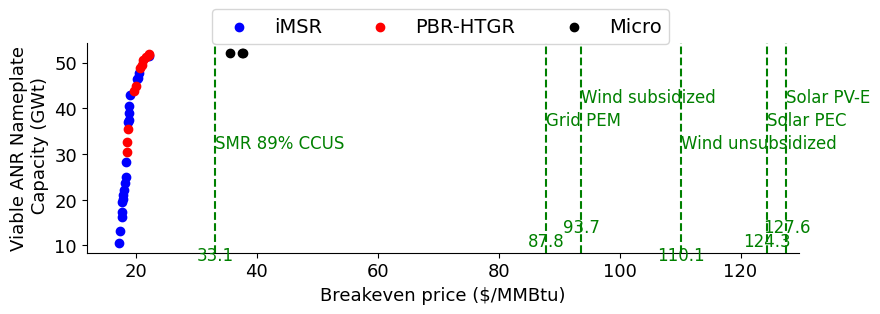

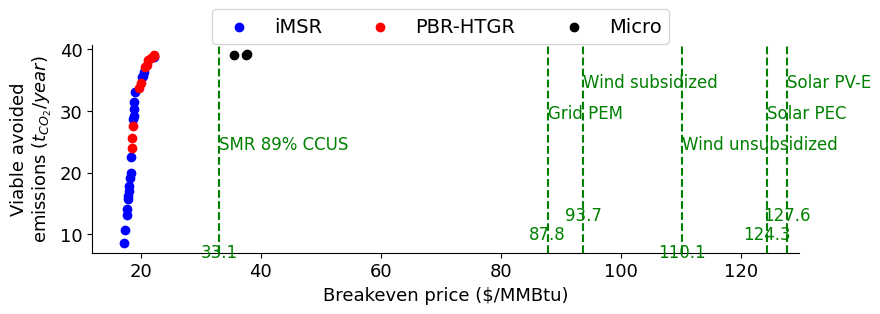

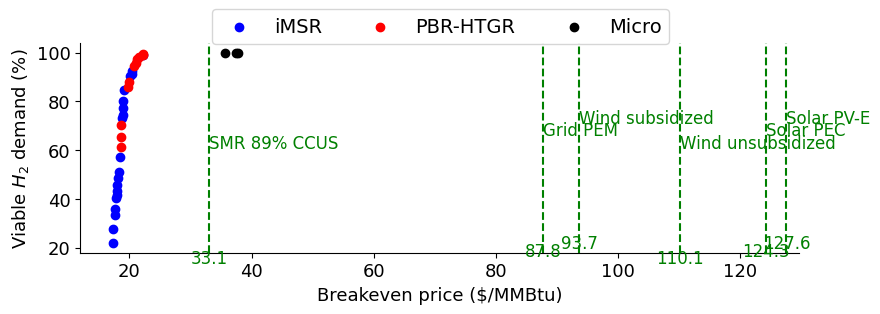

In [13]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 13
labels = {'ANR Nameplate Capacity (GWt)': ['Viable ANR Nameplate\n Capacity (GWt)', 'capacity'],
            'Viable avoided emissions (MMT-CO2/year)': ['Viable avoided\n'r'emissions ($t_{CO_2}/year$)', 'emission'],
            'Cum h2 dem (%)':[r'Viable $H_2$ demand (%)', 'h2_demand']}

def plot_against_be(df, col_name, y_label, save_label):
    anr_types = df['ANR type'].unique()
    colors = ['blue', 'red', 'black'] 
    fig, axs = plt.subplots(figsize=(9, 3))
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs.scatter(subset['Breakeven price ($/MMBtu)'], subset[col_name], color=color, label=f'{anr_type}')
    axs.set_ylabel(y_label)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)

    # Adding vertical lines and labels for competing RES 
    res_be = pd.read_csv('./results/res_be_ammonia.csv')
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    for l,line in enumerate(res_vert_lines):
        axs.axvline(x=line, linestyle='--',color='green')
        res_labels = res_be['RES']
    count = 0
    for x, label in zip(res_vert_lines, res_labels):
        axs.text(x, (axs.get_ylim()[1]+axs.get_ylim()[0])/2+5*np.mod(count,3), label, fontsize=12, color='green')
        axs.text(x, axs.get_ylim()[0]+3*np.mod(count,3)+1.5, str(x), color='green', fontsize=12, va='top',ha='center')
        count+=1
        # Setting the title and labels
    axs.set_xlabel('Breakeven price ($/MMBtu)')
    handles, labels = axs.get_legend_handles_labels()
    fig.legend(handles, labels,  bbox_to_anchor=(.5,1.08),loc='upper center', ncol=len(anr_types))
    fig.tight_layout()
    fig.savefig(save_fig_path+'_'+save_label+'.png', bbox_inches='tight')

for col_name, label_list in labels.items():
    plot_against_be(df, col_name, y_label=label_list[0], save_label=label_list[1])
